In [1]:
import sys
import os
import warnings

# Ajouter le répertoire parent pour inclure 'src'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

# Imports après avoir ajusté le sys.path
from src.backtester.back_tester import BackTesting
from src.strategies.strategies import *
from src.utils.utilities import Utilities
from src.performance.graph import IndexPlotter
import utils.constant as constant
from src.performance.metrics import MetricsCalculator

# Supprimer les avertissements FutureWarning et RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.float_format', '{:.3f}'.format)

<div style="background-color: rgb(15, 50, 110); color: white; padding: 15px; border-radius: 8px; box-shadow: 0 3px 6px 0 rgba(0, 0, 0, 0.2); text-align: center;">
    <h1 style="font-size: 32px; font-weight: bold; margin: 0;">Volatility Timing under Low-Volatility Strategy</h1>
</div> 

## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Volatility Strategies </span>

In [2]:
# data import
asset_indices_monthly = Utilities.load_asset_indices(["LowVolatilityDecile", "VolatilityTiming", 
                                                      "HighVolatilityDecile"], 
                                                    folder_subpath="asset_indices\\monthly_eq_weighted")

asset_indices_monthly_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", 
                                                          "HighVolatilityDecile", "VolatilityTiming", 
                                                          "VolatilityTiming2sided"], 
                                                          folder_subpath="asset_indices\\monthly_eq_weighted")

other_data = Utilities.get_data_from_pickle('other_US_data', folder_subpath="universe")

# Parameters
risk_free_rate_ticker = "US0003M Index"
ticker = "RIY INDEX"
start_date = datetime(2000,1,31)
end_date = datetime(2024,2,29)
frequency = "monthly"

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 1. Volatility and Return Profile under Different Market Conditions </span>

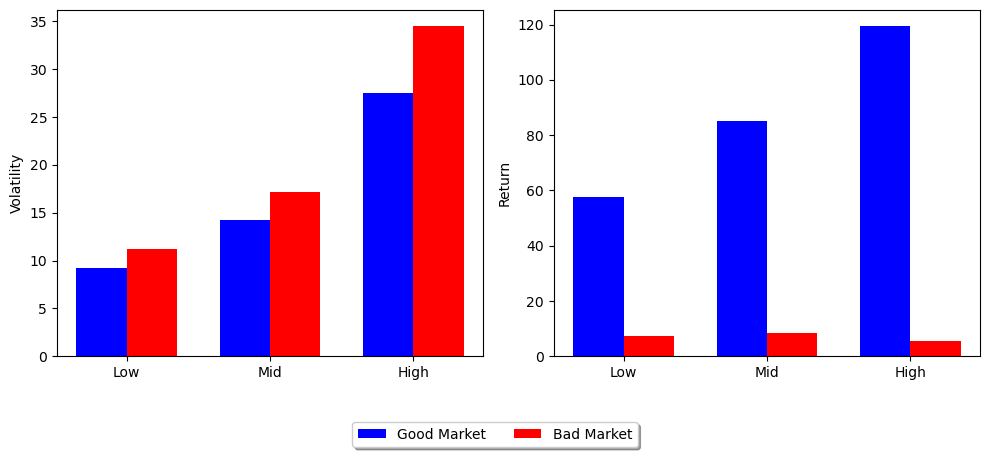

In [3]:
asset_indices = {ticker :item for ticker, item in asset_indices_monthly_all.items() if ticker in 
                 ["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile"]}

IndexPlotter.asset_indices_plot_under_diff_conditions(asset_indices, other_data, risk_free_rate_ticker,
                                                      start_date,end_date,
                                                      frequency, constant.REBALANCING_MOMENT, ticker)

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 2. Performance and Wealth Plots of the Volatility Strategies </span>

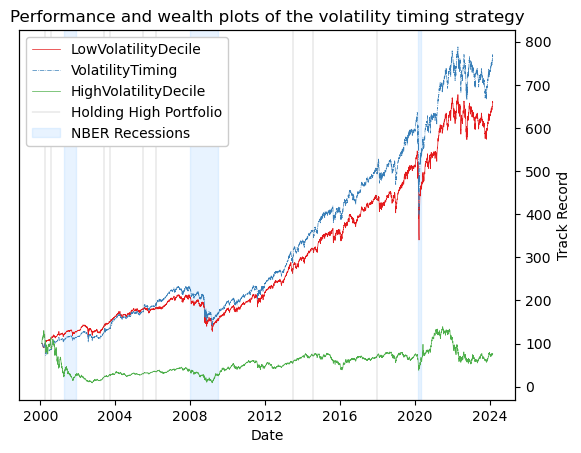

In [4]:
# Graph des tracks records Vol Timing
IndexPlotter.plot_track_records(asset_indices_monthly, other_data['USRINDEX Index'])

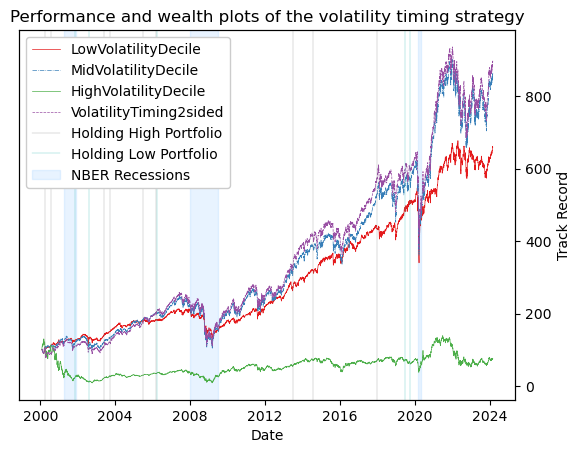

In [5]:
# Graph des tracks records des stratégies
asset_indices = {ticker :item for ticker, item in asset_indices_monthly_all.items() if ticker in 
                 ["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming2sided"]}

IndexPlotter.plot_track_records(asset_indices, other_data['USRINDEX Index'])

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  4. Performance and Risk Measures of the Various Volatility Portfolios </span>

In [6]:
perf_metrics_df = IndexPlotter.display_asset_indices_metrics(asset_indices_monthly_all, 
                                                             other_data,risk_free_rate_ticker)
perf_metrics_df

,Low Volatility,Mid Volatility,High Volatility,Volatility Timing,Volatility Timing 2-sided
Total Return,559.79%,764.51%,-24.10%,667.51%,797.90%
Annualized Return,8.77%,11.10%,7.53%,9.57%,11.40%
Annualized Volatility,13.55%,20.60%,41.70%,14.74%,21.25%
Monthly Volatility,3.91%,5.95%,12.04%,4.25%,6.14%
Daily Volatility,0.85%,1.30%,2.63%,0.93%,1.34%
Sharpe Ratio,0.586,0.499,0.161,0.593,0.497
Max Drawdown,-39.98%,-57.78%,-93.28%,-39.98%,-57.78%
SQRT (Semi-variance),11.23%,16.24%,30.20%,12.56%,16.98%
Sortino Ratio,0.707,0.633,0.222,0.696,0.623
Information Ratio,Benchmark,3.933,-0.277,3.851,3.942


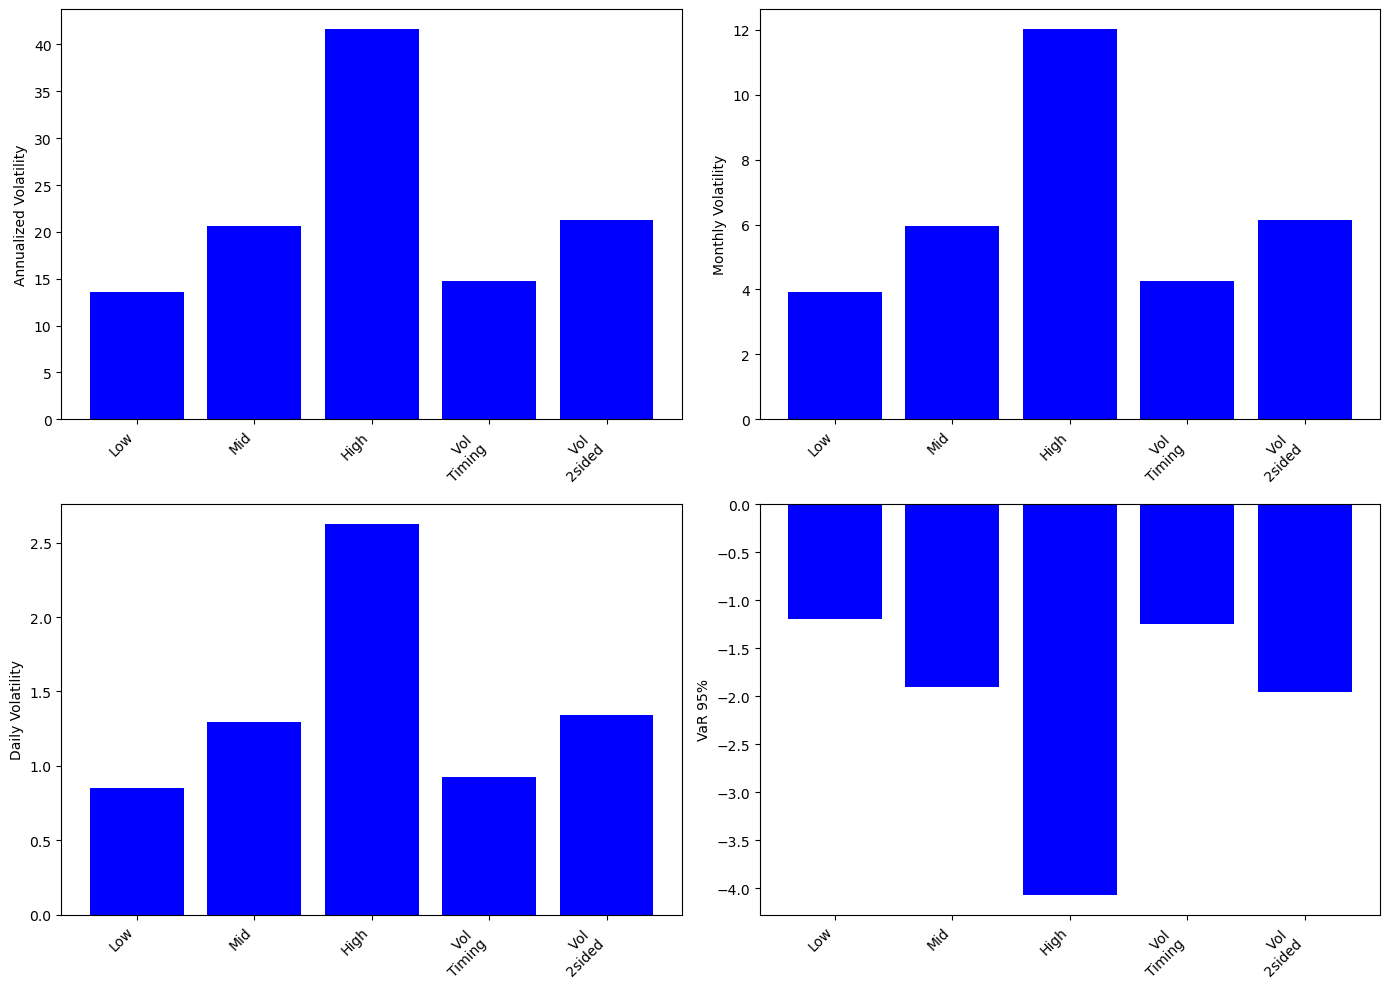

In [7]:
IndexPlotter.asset_indices_barplot(asset_indices_monthly_all, other_data, risk_free_rate_ticker)

## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Robustness Tests </span>


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  1. CAPM and Fama–French Alphas </span>

In [8]:
CPAM_stats, FF_stats = IndexPlotter.display_regress_statistics(asset_indices_monthly_all)
CPAM_stats

,α (%),β_mkt,R²
LowVol,0.411**,0.505**,0.529
,(2.901),(9.639),
MidVol,0.297*,1.002**,0.801
,(1.697),(16.907),
HighVol,-0.644*,2.091**,0.676
,(-1.689),(13.430),
VolTiming,0.445**,0.567**,0.501
,(2.702),(11.200),
Vol2Sided,0.303,1.040**,0.780
,(1.580),(18.942),


In [9]:
FF_stats

,α (%),β_mkt,β_SMB,β_HML,R²
LowVol,0.374**,0.546**,-0.190**,0.208**,0.627
,(3.437),(12.823),(-3.704),(3.343),
MidVol,0.217*,1.014**,-0.024,0.403**,0.877
,(1.882),(28.013),(-0.215),(6.119),
HighVol,-0.636*,1.894**,0.997**,-0.171,0.751
,(-1.928),(12.747),(6.876),(-0.897),
VolTiming,0.414**,0.601**,-0.157**,0.172**,0.552
,(2.991),(12.342),(-3.007),(2.560),
Vol2Sided,0.228*,1.045**,0.011,0.370**,0.837
,(1.707),(21.634),(0.099),(5.941),


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  2. Performance plots for various rebalancing frequencies </span>

In [10]:
# Chargement des indices
asset_indices_quaterly = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", 
                                              "VolatilityTiming", "VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\quarterly_eq_weighted")
asset_indices_semiannually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\semiannually_eq_weighted")
asset_indices_annually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\annually_eq_weighted")

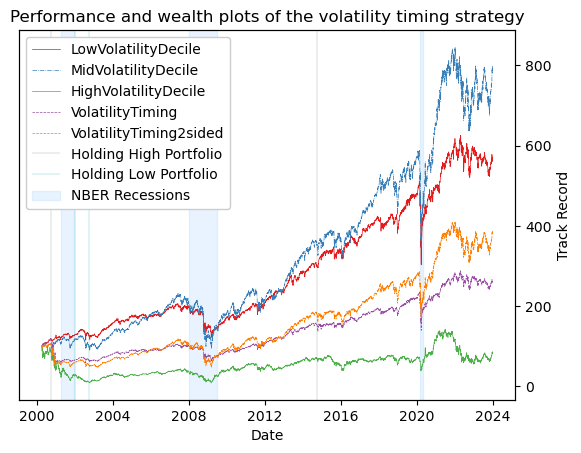

In [11]:
# Graph des tracks records des stratégies : rebalancement trimestriel (fin trimestre)
IndexPlotter.plot_track_records(asset_indices_quaterly, other_data['USRINDEX Index'])

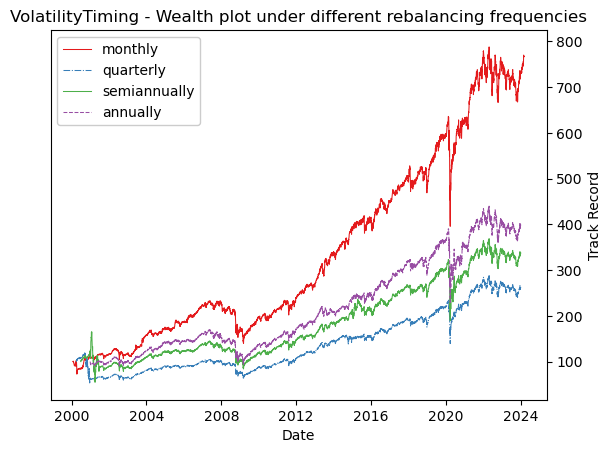

In [12]:
# Graphique des tracks records de la stratégie VolTiming pour différentes fréquences de rebalancement
IndexPlotter.plot_tracks_general( [asset_indices_monthly['VolatilityTiming'],
                                    asset_indices_quaterly['VolatilityTiming'],
                                    asset_indices_semiannually['VolatilityTiming'],
                                    asset_indices_annually['VolatilityTiming']],
                                    label_names=["monthly", "quarterly","semiannually","annually"],
                                    graph_title="VolatilityTiming - Wealth plot under different rebalancing frequencies")

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  3. Performance under transaction costs </span>

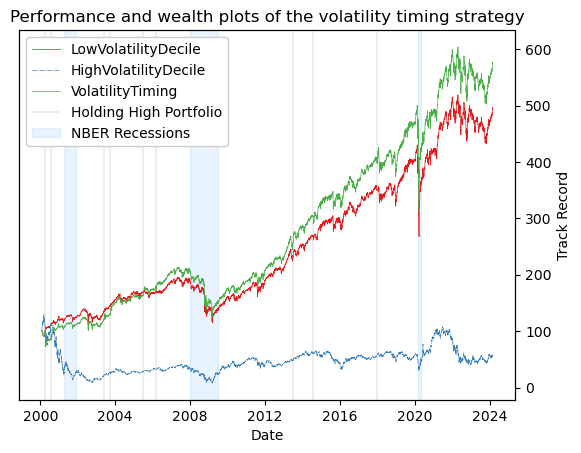

In [13]:
asset_indices_with_tc = Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_with_transaction_costs")

asset_indices_with_tc_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_with_transaction_costs")

IndexPlotter.plot_track_records(asset_indices_with_tc, other_data['USRINDEX Index'])

In [14]:
perf_metrics_with_tc_df = IndexPlotter.display_asset_indices_metrics(asset_indices_with_tc_all, 
                                                                     other_data, risk_free_rate_ticker)

IndexPlotter.display_joint_metrics(perf_metrics_df, perf_metrics_with_tc_df, 
                                   label_names=['Low Volatility','High Volatility','Volatility Timing'],
                                   column_names=["Without TC", "With TC"])

Low Volatility          High Volatility             \
                          Without TC  With TC      Without TC    With TC   
Total Return                 -24.10%  -43.13%         559.79%    394.17%   
Annualized Return              7.53%    6.33%           8.77%      7.57%   
Annualized Volatility         41.70%   41.70%          13.55%     13.55%   
Monthly Volatility            12.04%   12.04%           3.91%      3.91%   
Daily Volatility               2.63%    2.63%           0.85%      0.85%   
Sharpe Ratio                   0.161    0.132           0.586      0.497   
Max Drawdown                 -93.28%  -93.71%         -39.98%    -41.17%   
SQRT (Semi-variance)          30.20%   30.17%          11.23%     11.21%   
Sortino Ratio                  0.222    0.182           0.707      0.601   
Information Ratio             -0.277   -0.237       Benchmark  Benchmark   
Historical VaR (95%)          -4.07%   -4.07%          -1.20%     -1.20%   

                      Volatility Timing           
                             Without TC  With TC  
Total Return                    667.51%  474.86%  
Annualized Return                 9.57%    8.37%  
Annualized Volatility            14.74%   14.74%  
Monthly Volatility                4.25%    4.25%  
Daily Volatility                  0.93%    0.93%  
Sharpe Ratio                      0.593    0.512  
Max Drawdown                    -39.98%  -41.17%  
SQRT (Semi-variance)             12.56%   12.54%  
Sortino Ratio                     0.696    0.601  
Information Ratio                 3.851    4.099  
Historical VaR (95%)             -1.24%   -1.24%

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  4. Performance under different weighting choices </span>

In [15]:
# Data import
asset_indices_vol_scaling= Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_vol_scaling")

asset_indices_vol_scaling_all= Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_vol_scaling")

asset_indices_max_div = Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_max_div")


asset_indices_max_div_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_max_div")

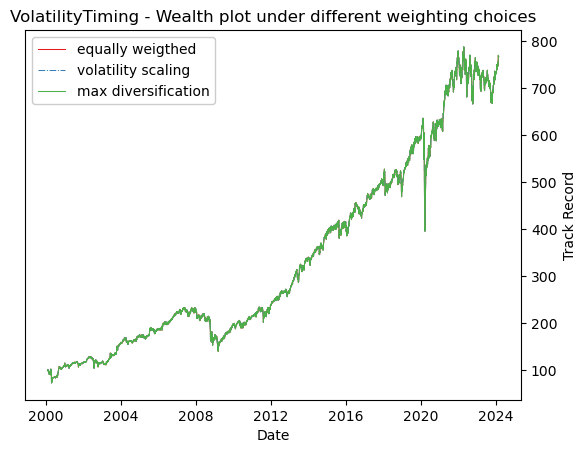

In [16]:
# Graphique des tracks records de la stratégie VolTiming pour différentes méthodes de calcul de poids
IndexPlotter.plot_tracks_general( [asset_indices_monthly_all['VolatilityTiming'],
                                    asset_indices_vol_scaling['VolatilityTiming'],
                                    asset_indices_max_div['VolatilityTiming']],
                                    label_names=["equally weigthed", "volatility scaling","max diversification"],
                                    graph_title="VolatilityTiming - Wealth plot under different weighting choices")

In [17]:
perf_metrics_vol_scaling_df = IndexPlotter.display_asset_indices_metrics(asset_indices_vol_scaling_all, 
                                                                     other_data, risk_free_rate_ticker)

perf_metrics_max_div_df = IndexPlotter.display_asset_indices_metrics(asset_indices_max_div_all, 
                                                                     other_data, risk_free_rate_ticker)

In [18]:
IndexPlotter.display_joint_metrics(perf_metrics_df, perf_metrics_vol_scaling_df,  perf_metrics_max_div_df,
                                   label_names=['High Volatility','Low Volatility','Volatility Timing'],
                                   column_names=["equally weigthed", "volatility scaling","max diversification"])

High Volatility                                         \
                      equally weigthed volatility scaling max diversification   
Total Return                   -24.10%            -31.80%             -24.10%   
Annualized Return                7.53%              7.00%               7.53%   
Annualized Volatility           41.70%             41.48%              41.70%   
Monthly Volatility              12.04%             11.97%              12.04%   
Daily Volatility                 2.63%              2.61%               2.63%   
Sharpe Ratio                     0.161              0.149               0.161   
Max Drawdown                   -93.28%            -94.17%             -93.28%   
SQRT (Semi-variance)            30.20%             29.99%              30.20%   
Sortino Ratio                    0.222              0.206               0.222   
Information Ratio               -0.277             -0.496              -0.277   
Historical VaR (95%)            -4.07%             -4.08%              -4.07%   

                        Low Volatility                                         \
                      equally weigthed volatility scaling max diversification   
Total Return                   559.79%            553.67%             559.79%   
Annualized Return                8.77%              8.73%               8.77%   
Annualized Volatility           13.55%             13.54%              13.55%   
Monthly Volatility               3.91%              3.91%               3.91%   
Daily Volatility                 0.85%              0.85%               0.85%   
Sharpe Ratio                     0.586              0.584               0.586   
Max Drawdown                   -39.98%            -40.34%             -39.98%   
SQRT (Semi-variance)            11.23%             11.23%              11.23%   
Sortino Ratio                    0.707              0.704               0.707   
Information Ratio            Benchmark          Benchmark           Benchmark   
Historical VaR (95%)            -1.20%             -1.20%              -1.20%   

                      Volatility Timing                                         
                       equally weigthed volatility scaling max diversification  
Total Return                    667.51%            643.50%             667.51%  
Annualized Return                 9.57%              9.47%               9.57%  
Annualized Volatility            14.74%             14.75%              14.74%  
Monthly Volatility                4.25%              4.26%               4.25%  
Daily Volatility                  0.93%              0.93%               0.93%  
Sharpe Ratio                      0.593              0.586               0.593  
Max Drawdown                    -39.98%            -39.98%             -39.98%  
SQRT (Semi-variance)             12.56%             12.57%              12.56%  
Sortino Ratio                     0.696              0.687               0.696  
Information Ratio                 3.851              3.685               3.851  
Historical VaR (95%)             -1.24%             -1.24%              -1.24%